In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc, math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

##### Set the size and styles of graphs

In [2]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set(style="whitegrid")

### Read the dataset
Data is given in different CSV files which we will need to merge afterwards. 

`train.csv` only contains the ID of the building and meter related information including our target variable to be predicted (`meter_reading`). This `building_id` is foreign key in `building_metadata.csv`. All the information related to the buildings are given in this file. 


Same goes for `weather_train.csv` and `building_metadata.csv` files with common column (foreign key) `site_id`. So all three files are related and we will have to join these tables later

In [3]:
%%time
metadata_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/building_metadata.csv')
train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/test.csv')
weather_train_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_train.csv')
weather_test_df = pd.read_csv('/kaggle/input/ashrae-energy-prediction/weather_test.csv')

CPU times: user 27.5 s, sys: 10.4 s, total: 37.9 s
Wall time: 37.4 s


In [4]:
## Function to reduce the memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
metadata_df = reduce_mem_usage(metadata_df)
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
weather_train_df = reduce_mem_usage(weather_train_df)
weather_test_df = reduce_mem_usage(weather_test_df)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


#### Get insights of shapes and first few data rows of all the files

In [6]:
print (f'Training data shape: {train_df.shape}')
print (f'Weather training shape: {weather_train_df.shape}')
print (f'Weather training shape: {weather_test_df.shape}')
print (f'Weather testing shape: {metadata_df.shape}')
print (f'Test data shape: {test_df.shape}')

Training data shape: (20216100, 4)
Weather training shape: (139773, 9)
Weather training shape: (277243, 9)
Weather testing shape: (1449, 6)
Test data shape: (41697600, 4)


In [7]:
train_df.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [8]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [9]:
metadata_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [10]:
test_df.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


#### Merge necessary files
As mentioned previously, to get a single dataframe for training and a single data frame for testing with all the feature included, we need to join the tables/files which are related by foreign keys. Let's first merge/join training data.

In [11]:
%%time
train_metadata_df = train_df.join(other=metadata_df.set_index('building_id'), on='building_id', how='left', lsuffix='_l', rsuffix='_r')
full_train_df = train_metadata_df.merge(right=weather_train_df, how='left')

CPU times: user 9.46 s, sys: 4.71 s, total: 14.2 s
Wall time: 13 s


In [12]:
full_train_df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


#### Reducing the memory usage
Let's delete unnecessary dataframes from memory to lower the memory usage

In [13]:
# Delete unnecessary dataframes to decrease memory usage
del train_df
del weather_train_df
del train_metadata_df

Now let's change the data types of necessary feature columns based on the range of the data values. This will lower the data usage. But **how**? Let's see. For example the datatype of feature `building_id` is `int64` but based on the range of this feature, it can be accomodated in lower range i.e. `int16`. So this will decrease the memory usage.

#### Let's do the same for test data

In [14]:
%%time
full_test_df = test_df.merge(metadata_df, on='building_id', how='left')
full_test_df = full_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')

CPU times: user 22.1 s, sys: 13.7 s, total: 35.8 s
Wall time: 33.2 s


#### Reducing the memory usage
Let's delete unnecessary dataframes from memory to lower the memory usage

In [15]:
# Delete unnecessary dataframes to decrease memory usage
del metadata_df
del weather_test_df
del test_df

Now let's change the data types of necessary feature columns based on the range of the data values. This will lower the data usage. But **how**? Let's see. For example the datatype of feature `building_id` is `int64` but based on the range of this feature, it can be accomodated in lower range i.e. `int16`. So this will decrease the memory usage.

## Exploratory Data Analysis
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data.

### Distribition of primary usage of buildings

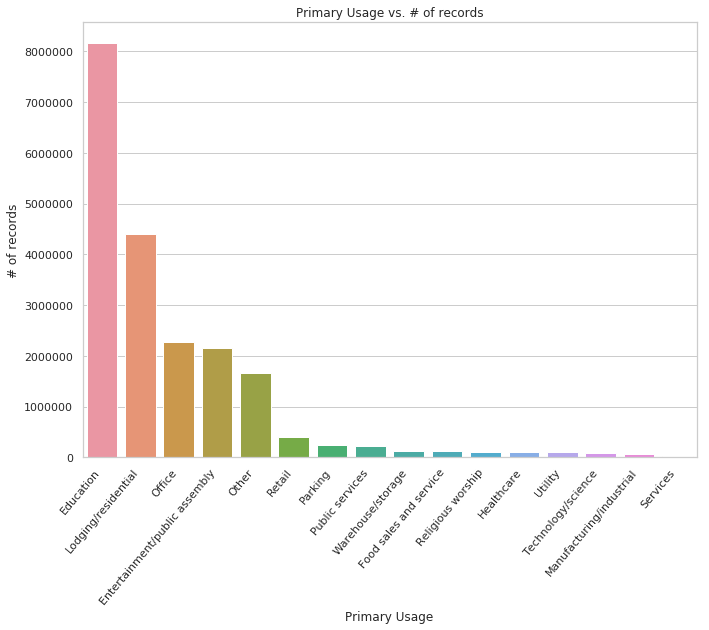

In [16]:
ax = sns.barplot(pd.unique(full_train_df['primary_use']), full_train_df['primary_use'].value_counts())
ax.set(xlabel='Primary Usage', ylabel='# of records', title='Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

### Distribution of meter types

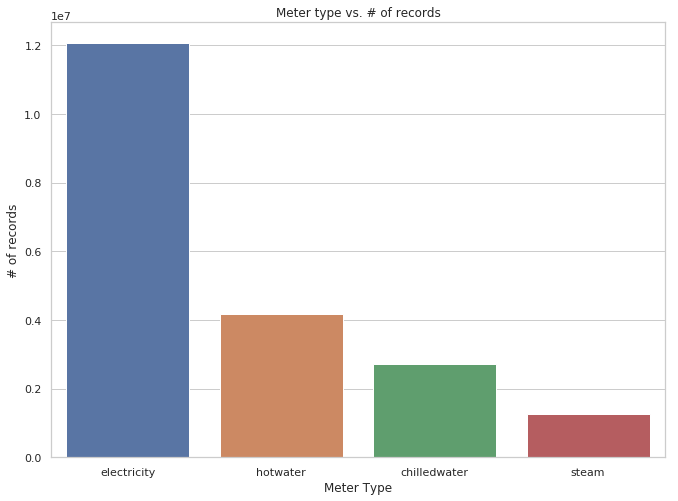

In [17]:
meter_types = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
ax = sns.barplot(np.vectorize(meter_types.get)(pd.unique(full_train_df['meter'])), full_train_df['meter'].value_counts())
ax.set(xlabel='Meter Type', ylabel='# of records', title='Meter type vs. # of records')
plt.show()

### Average meter reading for training dataset

In [18]:
# Average meter reading
print (f'Average meter reading: {full_train_df.meter_reading.mean()} kWh')

Average meter reading: 1988.7061767578125 kWh


### Distribution of meter readings for each meter type

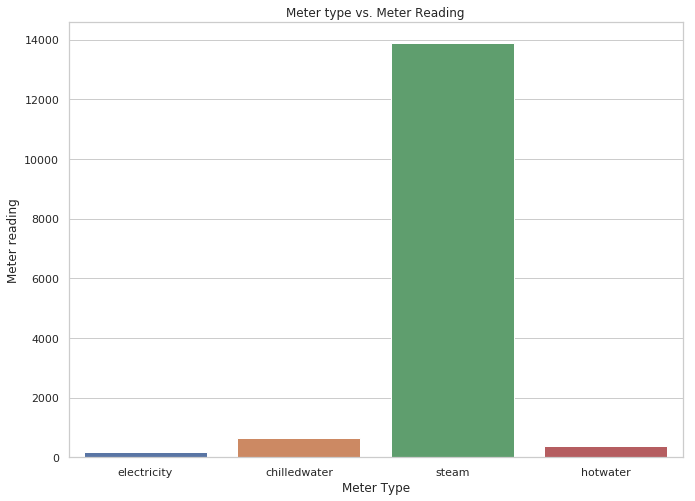

In [19]:
ax = sns.barplot(np.vectorize(meter_types.get)(full_train_df.groupby(['meter'])['meter_reading'].mean().keys()), full_train_df.groupby(['meter'])['meter_reading'].mean())
ax.set(xlabel='Meter Type', ylabel='Meter reading', title='Meter type vs. Meter Reading')
plt.show()

### Distribution of buildings built in each year for both training and test datasets

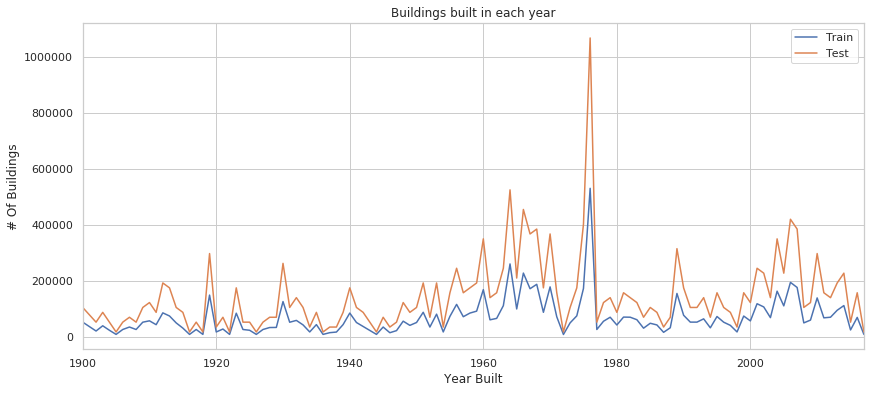

In [20]:
fig, ax = plt.subplots(1,1,figsize=(14, 6))
ax.set(xlabel='Year Built', ylabel='# Of Buildings', title='Buildings built in each year')
full_train_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax);
full_test_df['year_built'].value_counts(dropna=False).sort_index().plot(ax=ax);
ax.legend(['Train', 'Test']);

### Distribution of square feet area of buildings

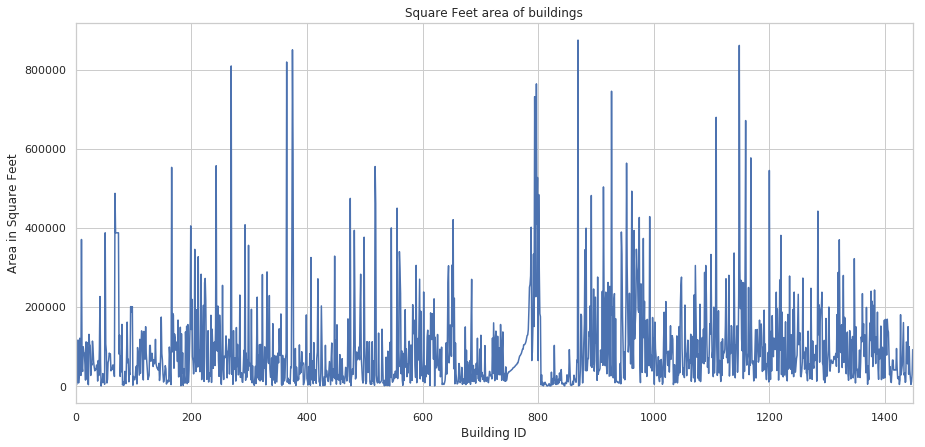

In [21]:
fig, ax = plt.subplots(1,1,figsize=(15, 7))
full_train_df.groupby(['building_id'])['square_feet'].mean().plot(ax=ax)
ax.set(xlabel='Building ID', ylabel='Area in Square Feet', title='Square Feet area of buildings')
plt.show()

## Feature Engineering
The joined dataframe (full_train_df) now has 20,216,100 rows, and 16 features in training dataset.

### Analysing missing data
First let's count and fill missing data in training datasets

In [22]:
pd.DataFrame(full_train_df.isna().sum().sort_values(ascending=False), columns=['NaN Count'])

,NaN Count
floor_count,16709167
year_built,12127645
cloud_coverage,8825365
precip_depth_1_hr,3749023
wind_direction,1449048
sea_level_pressure,1231669
wind_speed,143676
dew_temperature,100140
air_temperature,96658
square_feet,0


Let's see the ratio of available data to total data. Which signifies the percentage (%) availability of each feature in given dataset.

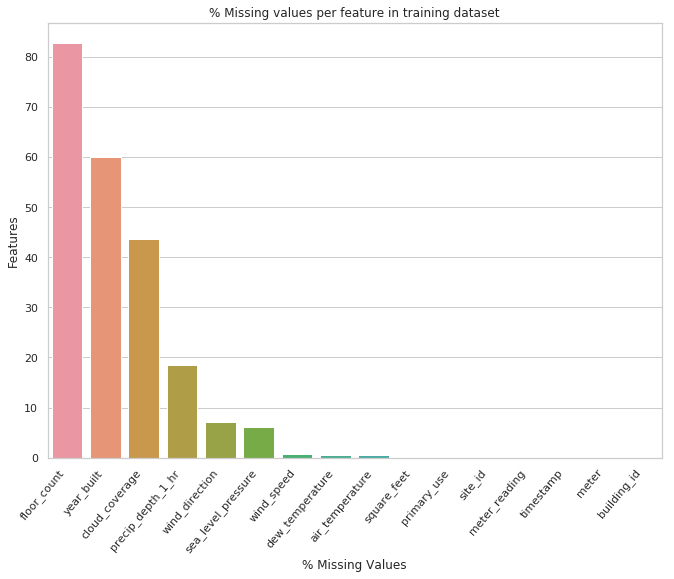

In [23]:
missing_values = (100-full_train_df.count() / len(full_train_df) * 100).sort_values(ascending=False)
ax = sns.barplot(missing_values.keys(), missing_values)
ax.set(xlabel='% Missing Values', ylabel='Features', title='% Missing values per feature in training dataset')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

Missing data can be filled in many ways. Here are few techniques to fill missing values: 

* Ignore the data row
* Back-fill or forward-fill to propagate next or previous values respectively
* Replace with some constant value outside fixed value range-999,-1 etc.
* Replace with mean, median value

For now, we will go with last method. So let's fill all the missing data with it's average(mean) values of corresponding columns.

In [24]:
def mean_without_overflow_fast(col):
    col /= len(col)
    return col.mean() * len(col)

In [25]:
%%time
missing_features = full_train_df.loc[:, missing_values > 0.0]
missing_features = missing_features.apply(mean_without_overflow_fast)

CPU times: user 1.4 s, sys: 1.9 s, total: 3.31 s
Wall time: 2.68 s


In [26]:
for key in full_train_df.loc[:, missing_values > 0.0].keys():
    if key == 'year_built' or key == 'floor_count':
        full_train_df[key].fillna(math.floor(missing_features[key]), inplace=True)
        full_test_df[key].fillna(math.floor(missing_features[key]), inplace=True)
    else:
        full_train_df[key].fillna(missing_features[key], inplace=True)
        full_test_df[key].fillna(missing_features[key], inplace=True)

In [27]:
full_train_df.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,4.0,1.700195,1.900391,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1968.0,4.0,1.700195,1.900391,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,4.0,1.700195,1.900391,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,4.0,1.700195,1.900391,-5.601562,-1.0,1008.5,180.0,8.796875
20216099,1448,0,2016-12-31 23:00:00,2.850000,15,Office,92271,2001.0,4.0,1.700195,1.900391,-5.601562,-1.0,1008.5,180.0,8.796875


In [28]:
full_test_df.tail()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914.0,4.0,15.984375,1.900391,7.746094,0.796387,1016.0,173.0,3.376953
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,1968.0,4.0,15.984375,1.900391,7.746094,0.796387,1016.0,173.0,3.376953
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997.0,4.0,15.984375,1.900391,7.746094,0.796387,1016.0,173.0,3.376953
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001.0,4.0,15.984375,1.900391,7.746094,0.796387,1016.0,173.0,3.376953
41697599,41697599,1448,0,2018-05-09 07:00:00,15,Office,92271,2001.0,4.0,15.984375,1.900391,7.746094,0.796387,1016.0,173.0,3.376953


Let's verify whether all the missing values are filled or not for both training and testing datasets

In [29]:
full_train_df.isna().sum()

building_id           0
meter                 0
timestamp             0
meter_reading         0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

In [30]:
full_test_df.isna().sum()

row_id                0
building_id           0
meter                 0
timestamp             0
site_id               0
primary_use           0
square_feet           0
year_built            0
floor_count           0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

So all the missing values for training and testing data is now filled with the mean of corresponding feature columns.

### Adding few more features

First let's expand timestamp to multiple components

In [31]:
full_train_df['timestamp'].dtype

dtype('O')

In [32]:
full_train_df["timestamp"] = pd.to_datetime(full_train_df["timestamp"])
full_test_df["timestamp"] = pd.to_datetime(full_test_df["timestamp"])

In [33]:
def transform(df):
    df['hour'] = np.uint8(df['timestamp'].dt.hour)
    df['day'] = np.uint8(df['timestamp'].dt.day)
    df['weekday'] = np.uint8(df['timestamp'].dt.weekday)
    df['month'] = np.uint8(df['timestamp'].dt.month)
    df['year'] = np.uint8(df['timestamp'].dt.year-1900)
    
    df['square_feet'] = np.log(df['square_feet'])
    
    return df

In [34]:
full_train_df = transform(full_train_df)
full_test_df = transform(full_test_df)

In [35]:
dates_range = pd.date_range(start='2015-12-31', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())
full_train_df['is_holiday'] = (full_train_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)
full_test_df['is_holiday'] = (full_test_df['timestamp'].dt.date.astype('datetime64').isin(us_holidays)).astype(np.int8)

In [36]:
# Assuming 5 days a week for all the given buildings
full_train_df.loc[(full_train_df['weekday'] == 5) | (full_train_df['weekday'] == 6) , 'is_holiday'] = 1
full_test_df.loc[(full_test_df['weekday']) == 5 | (full_test_df['weekday'] == 6) , 'is_holiday'] = 1

In [37]:
# Adding seasons as a feature
full_train_df.loc[(full_train_df['month'] >= 3) & (full_train_df['month'] <= 5) , 'season'] = 0
full_train_df.loc[(full_train_df['month'] >= 6) & (full_train_df['month'] <= 8) , 'season'] = 1
full_train_df.loc[(full_train_df['month'] >= 9) & (full_train_df['month'] <= 11) , 'season'] = 2
full_train_df.loc[(full_train_df['month'] == 12) | (full_train_df['month'] == 1) | (full_train_df['month'] == 2) , 'season'] = 3

full_test_df.loc[(full_test_df['month'] >= 3) & (full_test_df['month'] <= 5) , 'season'] = 0
full_test_df.loc[(full_test_df['month'] >= 6) & (full_test_df['month'] <= 8) , 'season'] = 1
full_test_df.loc[(full_test_df['month'] >= 9) & (full_test_df['month'] <= 11) , 'season'] = 2
full_test_df.loc[(full_test_df['month'] == 12) | (full_test_df['month'] == 1) | (full_test_df['month'] == 2) , 'season'] = 3

In [38]:
full_test_df = full_test_df.drop(['timestamp'], axis=1)
full_train_df = full_train_df.drop(['timestamp'], axis=1)
print (f'Shape of training dataset: {full_train_df.shape}')
print (f'Shape of testing dataset: {full_test_df.shape}')

Shape of training dataset: (20216100, 22)
Shape of testing dataset: (41697600, 22)


In [39]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,year,is_holiday,season
20216095,1444,0,8.750000,15,Entertainment/public assembly,9.884254,1914.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216096,1445,0,4.825000,15,Education,8.365905,1968.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216097,1446,0,0.000000,15,Entertainment/public assembly,9.329456,1997.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216098,1447,0,159.574997,15,Lodging/residential,10.301424,2001.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216099,1448,0,2.850000,15,Office,11.432485,2001.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0


In [40]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month,year,is_holiday,season
20216095,1444,0,8.750000,15,Entertainment/public assembly,9.884254,1914.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216096,1445,0,4.825000,15,Education,8.365905,1968.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216097,1446,0,0.000000,15,Entertainment/public assembly,9.329456,1997.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216098,1447,0,159.574997,15,Lodging/residential,10.301424,2001.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0
20216099,1448,0,2.850000,15,Office,11.432485,2001.0,4.0,1.700195,1.900391,...,1008.5,180.0,8.796875,23,31,5,12,116,1,3.0


In [41]:
## Reducing memory
full_train_df = reduce_mem_usage(full_train_df)
full_test_df = reduce_mem_usage(full_test_df)

Mem. usage decreased to 1002.54 Mb (18.8% reduction)
Mem. usage decreased to 2067.83 Mb (18.8% reduction)


In [42]:
def degToCompass(num):
    val=int((num/22.5)+.5)
    arr=[i for i in range(0,16)]
    return arr[(val % 16)]

In [43]:
full_train_df['wind_direction'] = full_train_df['wind_direction'].apply(degToCompass)

In [44]:
beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
          (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]

for item in beaufort:
    full_train_df.loc[(full_train_df['wind_speed']>=item[1]) & (full_train_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [45]:
le = LabelEncoder()
full_train_df['primary_use'] = le.fit_transform(full_train_df['primary_use'])

categoricals = ['site_id', 'building_id', 'primary_use', 'hour', 'weekday', 'meter',  'wind_direction', 'season', 'is_holiday']
drop_cols = ['sea_level_pressure', 'wind_speed']
numericals = ['square_feet', 'year_built', 'air_temperature', 'cloud_coverage',
              'dew_temperature', 'precip_depth_1_hr', 'floor_count', 'beaufort_scale']

feat_cols = categoricals + numericals

In [46]:
full_train_df.tail()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,wind_direction,wind_speed,hour,day,weekday,month,year,is_holiday,season,beaufort_scale
20216095,1444,0,8.750000,15,1,9.882812,1914.0,4.0,1.700195,1.900391,...,8,8.796875,23,31,5,12,116,1,3.0,5.0
20216096,1445,0,4.825000,15,0,8.367188,1968.0,4.0,1.700195,1.900391,...,8,8.796875,23,31,5,12,116,1,3.0,5.0
20216097,1446,0,0.000000,15,1,9.328125,1997.0,4.0,1.700195,1.900391,...,8,8.796875,23,31,5,12,116,1,3.0,5.0
20216098,1447,0,159.574997,15,4,10.304688,2001.0,4.0,1.700195,1.900391,...,8,8.796875,23,31,5,12,116,1,3.0,5.0
20216099,1448,0,2.850000,15,6,11.429688,2001.0,4.0,1.700195,1.900391,...,8,8.796875,23,31,5,12,116,1,3.0,5.0


In [47]:
target = np.log1p(full_train_df["meter_reading"])
del full_train_df["meter_reading"] 
full_train_df = full_train_df.drop(drop_cols, axis = 1)

In [48]:
# Save the testing dataset to freeup the RAM. We'll read after training
full_test_df.to_pickle('full_test_df.pkl')
del full_test_df

In [49]:
gc.collect()

22

In [50]:
full_train_df = reduce_mem_usage(full_train_df)

Mem. usage decreased to 732.62 Mb (34.5% reduction)


In [51]:
params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'subsample': 0.25,
            'subsample_freq': 1,
            'learning_rate': 0.4,
            'num_leaves': 18,
            'feature_fraction': 0.9,
            'lambda_l1': 1,  
            'lambda_l2': 1
            }

folds = 4
seed = 666

kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []
for train_index, val_index in kf.split(full_train_df, full_train_df['building_id']):
    train_X = full_train_df[feat_cols].iloc[train_index]
    val_X = full_train_df[feat_cols].iloc[val_index]
    train_y = target.iloc[train_index]
    val_y = target.iloc[val_index]
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
    lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train, lgb_eval),
                early_stopping_rounds=100,
                verbose_eval = 100)
    models.append(gbm)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.987944	valid_1's rmse: 0.988913
[200]	training's rmse: 0.939084	valid_1's rmse: 0.940598
[300]	training's rmse: 0.913017	valid_1's rmse: 0.915167
[400]	training's rmse: 0.895205	valid_1's rmse: 0.897965
[500]	training's rmse: 0.880232	valid_1's rmse: 0.883576
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.880232	valid_1's rmse: 0.883576
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.985721	valid_1's rmse: 0.98602
[200]	training's rmse: 0.936119	valid_1's rmse: 0.936695
[300]	training's rmse: 0.910683	valid_1's rmse: 0.91181
[400]	training's rmse: 0.892744	valid_1's rmse: 0.89431
[500]	training's rmse: 0.879073	valid_1's rmse: 0.881262
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.879073	valid_1's rmse: 0.881262
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.974875	va

In [52]:
del full_train_df, train_X, val_X, lgb_train, lgb_eval, train_y, val_y, target
gc.collect()

216

In [53]:
full_test_df = pd.read_pickle('full_test_df.pkl')

In [54]:
full_test_df["primary_use"] = le.transform(full_test_df["primary_use"])
full_test_df['wind_direction'] = full_test_df['wind_direction'].apply(degToCompass)

In [55]:
for item in beaufort:
    full_test_df.loc[(full_test_df['wind_speed']>=item[1]) & (full_test_df['wind_speed']<item[2]), 'beaufort_scale'] = item[0]

In [56]:
full_test_df = full_test_df[feat_cols]

In [57]:
i=0
res=[]
step_size = 50000
for j in tqdm(range(int(np.ceil(full_test_df.shape[0]/50000)))):
    res.append(np.expm1(sum([model.predict(full_test_df.iloc[i:i+step_size]) for model in models])/folds))
    i+=step_size

100%|██████████| 834/834 [27:39<00:00,  1.99s/it]


In [58]:
res = np.concatenate(res)

In [59]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission['meter_reading'] = res
submission.loc[submission['meter_reading']<0, 'meter_reading'] = 0
submission.to_csv('submission_fe_lgbm.csv', index=False)
submission

,row_id,meter_reading
0,0,1.888577
1,1,1.353396
2,2,0.308291
3,3,2.874905
4,4,7.014469
...,...,...
41697595,41697595,7.145852
41697596,41697596,4.867592
41697597,41697597,2.725946
41697598,41697598,157.306162


### Help me improve the kernel by your valuable suggestions and please upvote if you find this helpful!